# Basic Agent with Memory
* Goal: we will build a similar app to the one we built in the previous exercise, but in this case **we will add memory:**
    * act - the LLM calls a tool.
    * observe - the tool passes the output back to the LLM.
    * reason - the LLM decides what to do next (call another tool or respond directly).
    * **persist state** - use an in memory checkpointer to support long-running conversations with interruptions.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 007-agent-with-memory.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## LLM with several tools

In [6]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

# For this notebook we set parallel tool calling to false
# as math generally is done sequentially.
# The OpenAI model defaults to parallel tool calling for efficiency.
# You can learn more at https://python.langchain.com/docs/how_to/tool_calling_parallel/
llm_with_tools = chatModel4o.bind_tools(tools, parallel_tool_calls=False)

## Building an app (called graph in langgraph) that decides if chat with LLM or use tool

* Here you have a graphic representation of the app we will build:

![Simple graph](graph003.png)

## Define the State schema

* For this example, we will use the same MessagesState we used in the previous exercise:

In [7]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

## Define the first Node
* The Nodes of a graph are defined as python functions.
* The first argument of a Node function is the state. Because of that, in this exercise each node can access the key `messages`, with `state['messages']`.
* In this example, we will start with a node similar to the one we created in the previous exercise, **but this time with a SystemMessage**:

In [8]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Combine Nodes and Edges to build the Graph
* First, we initialize a StateGraph with the `MessagesState` class we defined above.
* Then, we add our nodes and edges.
* The `START` Node is a special node that sends user input to the graph, to indicate where to start our graph.
* **See how we are using the ToolNode LangGraph built-in component to create the tool-using node called "tools"**.
    * We use ToolNode to call the tool. 
* **See how we are adding the conditional edge with the tools_condition LangGraph built-in component as our router**.
* **The main difference between this app and the previous one is that here the tools node responds back to the assistant instead of going to the `END` Node**.
    * This is what is called the ReAct architecture: the LLM keeps using the tools until it gets a satisfactory response.
        * act - the LLM calls a tool.
        * observe - the tool passes the output back to the LLM.
        * reason - the LLM decides what to do next (call another tool or respond directly).
* **See how we do not have `END` Node**.
* We compile our graph to perform a few basic checks on the graph structure.
* Finally, we visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

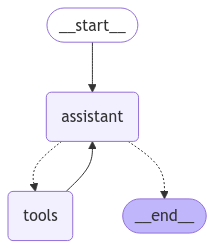

In [15]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add the logic of the graph
builder.add_edge(START, "assistant")

builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

# PAY ATTENTION HERE: from the tools node, back to the assistant
builder.add_edge("tools", "assistant")

# PAY ATTENTION: No END edgge.

# Compile the graph
react_graph = builder.compile()

# Visualize the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Run the app. Can it remember your previous input?
* The compiled graph implements the runnable protocol, a standard way to execute LangChain components. Because of that, we can use `invoke` as one of the standard methods to run this app.

In [10]:
messages = [HumanMessage(content="Add 3 and 4.")]

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_AKxpCcslEcimrNFvBEWZ2Ru3)
 Call ID: call_AKxpCcslEcimrNFvBEWZ2Ru3
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [11]:
messages = [HumanMessage(content="Multiply that by 2.")]

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

I need a specific number to multiply by 2. Could you please provide the number you want to multiply?


* **As you can see, the app does not remember the previous input/output, so it is unable to perform the last task correctly.**

## Adding Memory
* LangGraph can use the `MemorySaver` checkpointer to automatically save the graph state after each step.
* Do you remember the checkpoints we saw when we studied Cursor AI in the Generative AI Bootcamp? This is a similar concept:
    * The checkpointer saves the state at every step.
    * The checkpoints are saved in a thread.
    * We can access a thread using the thread_id.
* All we need to do is simply compile the graph with the checkpointer:

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# PAY ATTENTION HERE: see how we include the checkpointer
react_graph_memory = builder.compile(checkpointer=memory)

* **When we use memory, we need to specify a thread_id**. This thread_id will store our collection of states.
    * If your remember, we used a very similar approach when working with LangChain in the Generative AI Bootcamp. 

In [13]:
# PAY ATTENTION HERE: see how we specify a thread
config = {"configurable": {"thread_id": "1"}}

# Enter the input
messages = [HumanMessage(content="Add 3 and 4.")]

# PAY ATTENTION HERE: see how we add config to referr to the thread_id
messages = react_graph_memory.invoke({"messages": messages},config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_7lH6zvBw4rMeTG3Zu66i53eW)
 Call ID: call_7lH6zvBw4rMeTG3Zu66i53eW
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


* **If we keep same the config, the above conversation is captured in the state of the thread**.
* The HumanMessage we pass below ("Multiply that by 2.") will be appended to the above conversation. So the model now knows that the "that" in our last input refers to "The sum of 3 and 4 is 7".

In [14]:
# PAY ATTENTION HERE: see how we check if the app has memory
messages = [HumanMessage(content="Multiply that by 2.")]

# Again, see how we use config here to referr to the thread_id
messages = react_graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_7lH6zvBw4rMeTG3Zu66i53eW)
 Call ID: call_7lH6zvBw4rMeTG3Zu66i53eW
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_x3tKpGBsTHUCbVwzBr3PiNn1)
 Call ID: call_x3tKpGBsTHUCbVwzBr3PiNn1
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 007-agent-with-memory.py
* In terminal, make sure you are in the directory of the file and run:
    * python 007-agent-with-memory.py